<a href="https://colab.research.google.com/github/yscity2006/beatrice/blob/main/BeatriceV2_Trainer_Notebook_rev_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Beatrice V2 Trainer Notebook
---

### Instruction
[en]
- Please select one of the GPU runtime types.
- Click the run icon for each cell (1) ~ (6) to execute it.
- If a UI is displayed, please enter the required information into the UI.

[日]
- ランタイムのタイプはGPUのいずれかを選択してください。
- (1) ~ (6) の各セルの実行アイコンをクリックして実行してください。
- UIが表示される場合はそのUIに入力を行ってください。

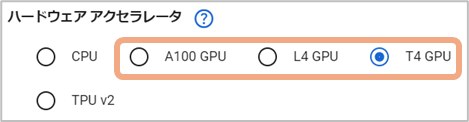
---

### Link
- beatrice-trainer

 https://huggingface.co/fierce-cats/beatrice-trainer



Training
---

In [1]:
# @title **(1) configuration**

# @markdown [en]
# @markdown Configure the environment.
# @markdown - Mode: Operation mode
# @markdown  - persistent: Retain the state of processes in Google Drive.
# @markdown  - temporary: Perform operations using only Colab's temporary storage.
# @markdown - Folder: Name of the working folder.
# @markdown - Data Folder: Folder for training data, which will be created within the working folder.
# @markdown - Output Folder: Folder for output, which will be created within the working folder.
# @markdown - Notification: Alert with a sound when the cell execution is complete.


# @markdown [日]
# @markdown 動作環境を設定します。
# @markdown - Mode: 動作モード
# @markdown  - persistent: Google Driveに処理の状態を残します。
# @markdown  - temporary: colabの一時領域のみで処理を行います。
# @markdown - Folder: 作業フォルダ名
# @markdown - Data Folder: トレーニングデータのフォルダ。作業フォルダ内に作成されます。
# @markdown - Output Folder: アウトプットフォルダ。作業フォルダ内に作成されます。
# @markdown - Notification: 音でセルの終了を知らせます。

from IPython.display import Audio, display
def play_notification_sound(url):
    display(Audio(url=url, autoplay=True))

import torch

import ipywidgets as widgets
from IPython.display import display,  HTML
from ipywidgets import HBox
from IPython.display import clear_output

mode = "persistent"
google_drive_path = "beatrice_v2"
enable_notification = "on"
data_dir = "data_dir"
output_dir = "output_dir"

def display_forms(device:str):
  clear_output()


  display(HTML("<style>.instruction { color:cadetblue;font-weight:300; font-size:1.5rem; line-height:auto }</style>"))
  display(HTML("<style>.runtime_type { color:darkgray;font-weight:300; font-size:1rem; line-height:auto }</style>"))
  display(HTML("<style>.runtime_type_warn { color:red;font-weight:300; font-size:1rem; line-height:auto }</style>"))
  display(HTML("<style>.item_label { color:darkgray;font-weight:700; width:7rem; padding-left:1rem }</style>"))

  instruction = widgets.Label(value='configure trainer options')
  instruction.add_class("instruction")

  if device == "cpu":
    runtime_type = widgets.Label(value=f"device: {device} !!! CPU is not supported.")
    runtime_type.add_class("runtime_type_warn")
  else:
    runtime_type = widgets.Label(value=f"device: {device}")
    runtime_type.add_class("runtime_type")


  mode_label = widgets.Label(value='Mode:')
  mode_label.add_class("item_label")

  mode_widget = widgets.ToggleButtons(
    options=['persistent', 'temporary'],
    value=mode,
  )

  google_drive_path_label = widgets.Label(value='Folder:')
  google_drive_path_label.add_class("item_label")

  google_drive_path_widget = widgets.Text(
    value=google_drive_path,
    placeholder=google_drive_path,
  )

  notification_label = widgets.Label(value='Notification:')
  notification_label.add_class("item_label")

  notification_widget = widgets.ToggleButtons(
    options=['on', 'off'],
    value=enable_notification
  )

  data_dir_label = widgets.Label(value='Data Folder:')
  data_dir_label.add_class("item_label")
  data_dir_widget = widgets.Text(
    value=data_dir,
    placeholder=data_dir,
  )
  output_dir_label = widgets.Label(value='Output Folder:')
  output_dir_label.add_class("item_label")
  output_dir_widget = widgets.Text(
    value=output_dir,
    placeholder=output_dir,
  )


  def on_mode_change(change):
    global mode
    mode = change['new']
    # if mode == "persistent":
    #   google_drive_path_widget.layout.display = 'block'
    #   google_drive_path_label.layout.display = 'block'
    # else:
    #   google_drive_path_widget.layout.display = 'none'
    #   google_drive_path_label.layout.display = 'none'

  def on_google_drive_path_change(change):
    global google_drive_path
    google_drive_path = change['new']

  def on_notification_change(change):
    global enable_notification
    enable_notification = change['new']


  def on_data_dir_change(change):
    global data_dir
    data_dir = change['new']

  def on_output_dir_change(change):
    global output_dir
    output_dir = change['new']


  mode_widget.observe(on_mode_change, names='value')
  google_drive_path_widget.observe(on_google_drive_path_change, names='value')
  notification_widget.observe(on_notification_change, names='value')
  data_dir_widget.observe(on_data_dir_change, names='value')
  output_dir_widget.observe(on_output_dir_change, names='value')


  display(instruction)
  display(runtime_type)
  hbox0 = HBox([mode_label, mode_widget])
  display(hbox0)
  hbox1 = HBox([google_drive_path_label, google_drive_path_widget])
  display(hbox1)
  hbox4 = HBox([data_dir_label, data_dir_widget])
  display(hbox4)
  hbox5 = HBox([output_dir_label, output_dir_widget])
  display(hbox5)
  hbox2 = HBox([notification_label, notification_widget])
  display(hbox2)


if torch.cuda.is_available():
  device = torch.cuda.get_device_name(0)
else:
  device = "cpu"

display_forms(device)


Label(value='configure trainer options', _dom_classes=('instruction',))

Label(value='device: Tesla T4', _dom_classes=('runtime_type',))

In [2]:
# @title **(2) setup environments** (This takes 2-3 minutes.)

from pathlib import Path
import contextlib
import io
import os

# create work dir and move
def create_work_dir(mode, google_drive_path):
  if mode == "persistent":
    from google.colab import drive
    dirve_mount_path = Path("/content/drive")
    google_drive_path = google_drive_path[1:] if google_drive_path.startswith("/") else google_drive_path
    work_dir = dirve_mount_path /"MyDrive"/ google_drive_path
    if not os.path.exists(dirve_mount_path):
      drive.mount(dirve_mount_path.as_posix())
    work_dir.mkdir(parents=True, exist_ok=True)
  else:
    work_dir = Path("/content") / google_drive_path
  return work_dir

def install_modules():
  print("Installing base modules...")
  print(f"You can see logs at {work_dir}/install_module.log")
  !pip install poetry colab-easy-ui==0.1.115  pyworld==0.3.4&> {work_dir}/install_module.log
  # !pip install poetry colab-easy-ui==0.1.115 torch==2.2.2 torchaudio==2.2.2 numpy==1.26.4 soundfile==0.11.0 pyworld==0.3.4&> {work_dir}/install_module.log
  # !pip install poetry colab-easy-ui==0.1.115 torch==2.2.2 torchaudio==2.2.2 numpy==1.26.4 soundfile==0.11.0 pyworld==0.3.4

def download_trainer_and_move():
  !git clone https://huggingface.co/fierce-cats/beatrice-trainer
  %cd beatrice-trainer
  !git lfs install
  !git lfs pull

work_dir = create_work_dir(mode, google_drive_path)
data_dir = work_dir / data_dir
output_dir = work_dir / output_dir
upload_dir = work_dir / "upload"
data_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)
upload_dir.mkdir(parents=True, exist_ok=True)

install_modules()
download_trainer_and_move()

# print(work_dir)
# print(data_dir)
# print(output_dir)
print("fin.")
if enable_notification == "on":
  play_notification_sound("https://github.com/w-okada/beatrice-trainer-colab/raw/master/resources/voices/complete.wav")


Mounted at /content/drive
Installing base modules...
You can see logs at /content/drive/MyDrive/beatrice_v2/install_module.log
Cloning into 'beatrice-trainer'...
remote: Enumerating objects: 3091, done.
remote: Counting objects: 100% (3091/3091), done.
remote: Compressing objects: 100% (3086/3086), done.
remote: Total 3091 (delta 29), reused 3022 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3091/3091), 2.45 MiB | 9.81 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Filtering content: 100% (2003/2003), 475.77 MiB | 27.33 MiB/s, done.
/content/beatrice-trainer
Updated git hooks.
Git LFS initialized.
fin.


In [5]:
# @title **(3) upload training data**
# @markdown [en]
# @markdown - If there's an alternative way to upload training data, you can skip this step.
# @markdown - Please create a zip file such that each audio folder becomes the first level of the hierarchy, then upload it. Ensure that all filenames and folder names within the zip file use only ASCII (alphabet or numbers).


# @markdown [日]
# @markdown - ほかの手段でトレーニングデータをアップロードできる場合は、スキップしてください。
# @markdown - 各音声フォルダが第1階層になるようにzipを作成してアップロードしてください。zipの中身のファイル名、フォルダ名はすべてascii(アルファベットか数字)を用いるようにしてください。


In [6]:
# @title **(3-1) upload training data (up to 1GB)**
from colab_easy_ui.simple_fileuploader import wrapped_run_server
from colab_easy_ui.const import  start_colab_IF
from IPython import get_ipython

ipython = get_ipython()
port = 8877
wrapped_run_server(ipython=ipython, port=port, upload_dir=upload_dir, file_title="training data(zip)", file_name="voice.zip")
start_colab_IF(port=port)

[debug] open http://localhost:8877/front


In [ ]:
# @title **(3-2) extract training data**
# @markdown ***!!! Notification !!!***

# @markdown [en] Please execute this after the "upload training data" progress reaches 100%.

# @markdown [日] "upload training data"の進捗が100%になってから実行してください。

import zipfile
from tqdm import tqdm
import os
def unzip_with_progress(zip_path, extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        members = zip_ref.infolist()
        for member in tqdm(members, desc='Extracting'):
            zip_ref.extract(member, extract_dir)

unzip_with_progress(upload_dir/"voice.zip", data_dir)

if enable_notification == "on":
  play_notification_sound("https://github.com/w-okada/beatrice-trainer-colab/raw/master/resources/voices/complete.wav")


In [ ]:
# @title **(4) launch tensorboard**

from google.colab.output import eval_js
import os
PORT=18002
# %load_ext tensorboard
# %tensorboard --logdir=output --port {PORT}
os.system(f'tensorboard --logdir={output_dir} --host 0.0.0.0 --port {PORT} &')
proxy = eval_js( "google.colab.kernel.proxyPort(" + str(PORT) + ")" )
print(f"tensorboard launched at {proxy}")

In [ ]:
# @title **(5) start training**
# @markdown [EN]
# @markdown It takes about 4-5 hours on T4 to complete the training.

# @markdown [日]
# @markdown トレーニング完了まで、T4で４～５時間程度かかります。(A100だと1時間強)

#!poetry run python beatrice_trainer -d {data_dir} -o {output_dir}
!python beatrice_trainer -d {data_dir} -o {output_dir}

if enable_notification == "on":
  play_notification_sound("https://github.com/w-okada/beatrice-trainer-colab/raw/master/resources/voices/complete.wav")


In [ ]:
# @title **(6) download**

import ipywidgets as widgets
from IPython.display import display
import os
import zipfile
import tempfile
from google.colab import files

def zip_and_download(selected_folder):
    try:
        # 一時的なディレクトリに圧縮ファイルを保存
        with tempfile.NamedTemporaryFile(suffix=".zip", delete=False) as temp_file:
            zip_file_path = temp_file.name
        # フォルダを圧縮
        folder_path = os.path.join(output_dir, selected_folder)
        with zipfile.ZipFile(zip_file_path, "w", zipfile.ZIP_DEFLATED) as zipf:
            for root, _, in_files in os.walk(folder_path):
                for file in in_files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, start=output_dir)
                    zipf.write(file_path, arcname)
        !cp {zip_file_path} /content/{selected_folder}.zip


        # ファイルをダウンロード
        files.download(f"/content/{selected_folder}.zip")

    except Exception as e:
        print(f"Error during compression and download: {e}")



def display_ui(folders):
    def on_button_clicked(b):
        selected_folder = select_folder.value
        if selected_folder:
            zip_and_download(selected_folder)
        else:
            print("No folder selected")

    label = widgets.Label(value="Select folder...")
    select_folder = widgets.Select(
        options=folders,
        value=folders[-1] if folders else None,  # デフォルトではソートしたときに最も後ろに来るものを選択
        disabled=False,
        layout=widgets.Layout(width='50%'),
    )
    button = widgets.Button(description="Compress and Download", disabled=False, button_style="", tooltip="Click to compress and download selected folder")
    button.on_click(on_button_clicked)
    display(label)
    display(select_folder)
    display(button)

folders = sorted([name for name in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, name))])
display_ui(folders)


In [ ]:
# @title **(a1) delete working folder**
# @markdown [en]
# @markdown - We will delete the Beatrice v2 working folder on Google Drive. Deleted files cannot be recovered, so please make sure to double-check before proceeding.
# @markdown - Please copy the command output in this cell and execute it in a new cell.

# @markdown [日]
# @markdown - Google Drive上のBeatriceの作業フォルダを削除します。削除されたファイルは復元できないので十分確認の上実行してください。
# @markdown - このセルで出力されるコマンドをコピーして新しいセルで実行してください。

if len(google_drive_path) > 0:
  print(f"!rm -rf {work_dir}")
else:
  print("no working folder")